# Concentric spheres data

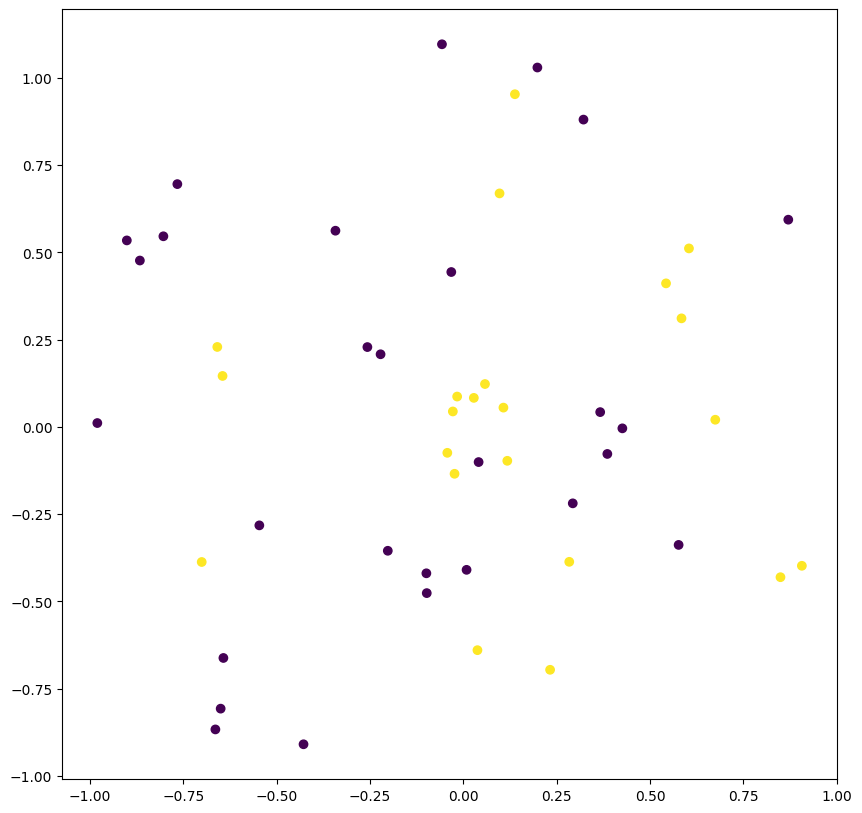

In [1]:
import os, sys, time, math, numpy, torch, matplotlib.pyplot

sys.path.append(os.path.abspath(os.path.join('..')))  # Allow repository modules to be imported

from settings.concentric_spheres import get_dataloader
from utils.optimization import initialize

data_setting = {
    'seed': 1234,
    'input_dimension': 100, 
    'spheres_dimension': 2, 
    'number_of_spheres': 4, 
    'sample_size': 5000, 
    'batch_size': 50, 
    'margin': 0.3, 
    'gaussian_noise_std': .05,
    'label_flipping': .15
}

model_setting = {
    'epochs': 10000,
    'learning_rate': 0.1,
    'batch_size': data_setting['batch_size'],
    'initial_hidden_units': 3,
    'bias': True,
    'initialization_variance': 1. / data_setting['input_dimension'] ** 1.2
}

experiment = {
    **data_setting,
    **model_setting,
    'convergence_epsilon': 1e-4,
    'train': 'cross entropy',
    'test': 'cross entropy',
    'train_time': 'seconds',
    'models_runs': []
}

initialize(data_setting['seed'])

data, rotation_matrix = get_dataloader(**data_setting)
_, (inputs, labels) = next(enumerate(data))

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels)

In [9]:
class GrowingNeuralNet(torch.nn.Module):

    def __init__(self, input_dimension:int, learning_rate:float=0., margin:float=0., noise_rate:float=0., input_domain_radious:float=1.,
                 initial_hidden_units:int=1, initial_depth:int=1, bias:bool=True, *args, **kwargs):
        super(GrowingNeuralNet, self).__init__()

        self.device = 'cpu'
        self.input_dimension = input_dimension
        self.initial_hidden_units = initial_hidden_units
        self.learning_rate = learning_rate
        self.margin = margin
        self.noise_rate = noise_rate
        self.input_domain_radious = input_domain_radious
        self.bias = bias
        self.layers = [torch.nn.Linear(input_dimension if layer_index == 0 else initial_hidden_units, initial_hidden_units, bias=bias) 
                       for layer_index in range(initial_depth)]
        self.residual_norm = numpy.nan
        self.gradients_average_norm = [[numpy.nan,] * initial_hidden_units, ] * initial_depth
        self.average_gradient_norm = [[numpy.nan,] * initial_hidden_units, ] * initial_depth
        self.residual_projection_norm = [[numpy.nan,] * initial_hidden_units, ] * initial_depth
        self.residual_projection_upper_bounds = [[numpy.nan,] * initial_hidden_units, ] * initial_depth
        self.residual_projection_std = [[numpy.nan,] * initial_hidden_units, ] * initial_depth
        self.kernels = [[numpy.nan,] * initial_hidden_units, ] * initial_depth
        self.residual_projections = [[numpy.nan,] * initial_hidden_units, ] * initial_depth
        
        with torch.no_grad(): 
            for layer in self.layers: layer.bias.copy_(torch.zeros(initial_hidden_units))
            
        self.activation_function = torch.nn.ReLU()
        self.output_layer_weights = torch.tensor(([1. / initial_hidden_units ** 0.5] * math.ceil(initial_hidden_units / 2.) + 
                                                  [-1. / initial_hidden_units ** 0.5] * (initial_hidden_units // 2)))
        
    @property        
    def depth(self):
        return len(self.layers) + 1

    def parameters(self):
        parameters = []
        for layer in self.layers: parameters += list(layer.parameters())
        return parameters
        
    def forward(self, x):
        x = x.requires_grad_()
        x.retain_grad()
        self.pre_activations = []
        self.activations = [x]
        for layer in self.layers:
            pre_activation = layer(x).requires_grad_()
            pre_activation.retain_grad()
            self.pre_activations.append(pre_activation)
            activation = self.activation_function(pre_activation).requires_grad_()
            activation.retain_grad()
            self.activations.append(activation)
            x = activation
            
        self.output = torch.matmul(activation, self.output_layer_weights).unsqueeze(1).requires_grad_()
        self.output.retain_grad()
        return self.output

    def to(self, device):
        super().to(device)
        for layer_index, layer in enumerate(self.layers):
            self.layers[layer_index] = layer.to(device)

        self.output_layer_weights = self.output_layer_weights.to(device)
        self.device = device
        return self
    
    def calculate_layers_metrics(self):
        residual = self.output.grad.squeeze() * self.output.shape[0]
        self.residual_norm = residual.norm().item()
        self.output.backward(torch.ones_like(self.output), retain_graph=True)
        for layer_index, (inputs, pre_activation) in enumerate(zip(self.activations[:-1], self.pre_activations)):
            per_sample_gradients = pre_activation.grad.unsqueeze(-1).bmm(inputs.unsqueeze(1)).permute(1, 0, 2)
            self.gradients_average_norm[layer_index] = per_sample_gradients.norm(dim=2).mean(dim=1).tolist()
            self.average_gradient_norm[layer_index] = per_sample_gradients.mean(dim=0).norm(dim=1).tolist()

            per_sample_gradients_t = per_sample_gradients.permute(0, 2, 1)
            kernels = per_sample_gradients.bmm(torch.inverse(per_sample_gradients_t.bmm(per_sample_gradients)).bmm(per_sample_gradients_t))
            self.kernels[layer_index] = kernels
            residual_projections = torch.matmul(kernels, residual)
            self.residual_projections[layer_index] = residual_projections
            number_of_active_samples = (residual_projections != 0).count_nonzero(dim=1)
            residual_projection_upper_bounds = (
                    (1. / 2.) ** (3. / 2.) +                                # maximum variance assuming a Bernoulli distribution over align predictions.
                    (self.noise_rate * (1. - self.noise_rate)) ** (1. / 2.)   # maximum variance assuming a the noisy samples follow a Bernoulli process.
            ) / number_of_active_samples ** 0.5
            residual_projection_std = torch.std(residual_projections, dim=1)
            self.residual_projection_norm[layer_index] = residual_projections.norm(dim=1).tolist()
            self.residual_projection_upper_bounds[layer_index] = residual_projection_upper_bounds.tolist()
            self.residual_projection_std[layer_index] = residual_projection_std.tolist()

    def remove_dead_units(self):
        has_removed_units = False
        for layer_index, (inputs, pre_activation) in enumerate(zip(self.activations[:-1], self.pre_activations)):
            per_sample_gradients = pre_activation.grad.unsqueeze(-1).bmm(inputs.unsqueeze(1))
            dead_units = (per_sample_gradients.norm(dim=0).norm(dim=1) == 0).nonzero().reshape(-1).detach().cpu().tolist()
            if dead_units: 
                self.remove_dead_units_from_layer(dead_units, layer_index)
                has_removed_units = True
            
        return has_removed_units
    
    def remove_dead_units_from_layer(self, dead_units, layer_index):
        input_dimension = self.input_dimension if layer_index == 0 else self.layers[layer_index - 1].weight.shape[0]
        number_of_units = self.layers[layer_index].weight.shape[0]
        if len(dead_units) == number_of_units: 
            self.layers[layer_index] = torch.nn.Linear(
                input_dimension if layer_index == 0 else self.initial_hidden_units, self.initial_hidden_units, 
                bias=self.bias
            )
            for next_layers in range(layer_index + 1, len(self.layers)): 
                del self.layers[next_layers]

            self.output_layer_weights = torch.tensor(
                [1. / self.initial_hidden_units ** 0.5,] * math.ceil(self.initial_hidden_units / 2.) + 
                [-1. / self.initial_hidden_units ** 0.5,] * (self.initial_hidden_units // 2)
            )
            print(f'All {len(dead_units)} units at layer {layer_index} are dead. The network is reinitialized from layer {layer_index} to be of depth {self.depth}')

        else:
            alive_units = [unit_index for unit_index in range(number_of_units) if unit_index not in dead_units]
            alive_units_weights = self.layers[layer_index].weight.data[alive_units]
            alive_units_biases = self.layers[layer_index].bias.data[alive_units]
            self.layers[layer_index] = torch.nn.Linear(input_dimension, len(alive_units), bias=self.bias).to(self.device)
            with torch.no_grad():
                self.layers[layer_index].weight.copy_(alive_units_weights)
                self.layers[layer_index].bias.copy_(alive_units_biases)

            if layer_index == len(self.layers) - 1: 
                self.output_layer_weights = self.output_layer_weights[alive_units].clone()

            else:
                next_layer_units = self.layers[layer_index + 1].weight.shape[0]
                next_layer_alive_units_weights = self.layers[layer_index + 1].weight[:, alive_units].clone()
                next_layer_alive_units_biases = self.layers[layer_index + 1].bias.data.clone()
                self.layers[layer_index + 1] = torch.nn.Linear(len(alive_units), next_layer_units, bias=self.bias).to(self.device)
                with torch.no_grad():
                    self.layers[layer_index + 1].weight.copy_(next_layer_alive_units_weights)
                    self.layers[layer_index + 1].bias.copy_(next_layer_alive_units_biases)

            print(f'{len(dead_units)} units at layer {layer_index} are dead and were removed')
    
    def grow(self):
        for layer_index in range(self.depth - 1):
            samples_not_captured = (self.residual_projections[layer_index].norm(dim=0) == 0).nonzero().squeeze().detach().cpu().tolist()
            units_with_variance_beyond_worst_case = (
                torch.tensor(self.residual_projection_upper_bounds[layer_index]) < torch.tensor(self.residual_projection_std[layer_index])
            ).count_nonzero()
                
            if samples_not_captured:
                self.grow_width(layer_index, samples_not_captured)
                return True
            
            if units_with_variance_beyond_worst_case:
                self.grow_depth(layer_index)
                return True

            return False
                    
    def grow_width(self, layer_index, samples_not_captured):
        former_weights = self.layers[layer_index].weight.data.clone()
        former_biases = self.layers[layer_index].bias.data.clone()
        input_dimension = former_weights.shape[1]
        hidden_units = former_weights.shape[0]
        self.layers[layer_index] = torch.nn.Linear(input_dimension, hidden_units + 2, bias=self.bias).to(self.device)
        with torch.no_grad():
            self.layers[layer_index].weight[:-2].copy_(former_weights)
            self.layers[layer_index].bias[:-2].copy_(former_biases)
            self.layers[layer_index].weight[-2:].copy_(self.activations[layer_index][samples_not_captured].mean(dim=0).unsqueeze(0).repeat(2, 1))
            self.layers[layer_index].bias[-2:].copy_(torch.tensor([0.,] * 2).to(self.device))

        if layer_index == self.depth - 2:    
            next_layer_new_units_weights = torch.tensor([-1., 1.]).to(self.device) / (hidden_units + 2) ** 0.5
            self.output_layer_weights = torch.cat([self.output_layer_weights, next_layer_new_units_weights]).sign()
        
        else:
            next_layer_weights = self.layers[layer_index + 1].weight.data.clone()
            next_layer_biases = self.layers[layer_index + 1].bias.data.clone()
            next_layer_hidden_units = self.layers[layer_index + 1].weight.shape[0]
            next_layer_influence_in_output = self.pre_activations[layer_index + 1].grad[samples_not_captured].mean(dim=0).sign()
            next_layer_influence_in_output[next_layer_influence_in_output==0.] = 1.
            next_layer_new_units_weights = torch.tensor([[-1., 1.],] * next_layer_hidden_units).to(self.device) / (hidden_units + 2) ** 0.5
            next_layer_new_weights = torch.cat([next_layer_weights, next_layer_new_units_weights], dim=1)
            self.layers[layer_index + 1] = torch.nn.Linear(hidden_units + 2, next_layer_hidden_units, bias=self.bias).to(self.device)
            with torch.no_grad():
                self.layers[layer_index + 1].weight.copy_(next_layer_new_weights)
                self.layers[layer_index + 1].bias.copy_(next_layer_biases)
        
        print(f'Width growth: Two unit with opposing signs were added to layer {layer_index} which now has {hidden_units + 2} units')

    def grow_depth(self, layer_index):
        hidden_units = self.layers[layer_index].weight.shape[0]
        self.layers.insert(layer_index + 1, torch.nn.Linear(hidden_units, hidden_units, self.bias).to(self.device))
        with torch.no_grad():
            self.layers[layer_index + 1].weight.copy_(torch.eye(hidden_units).to(self.device))
            self.layers[layer_index + 1].bias.copy_(torch.zeros(hidden_units).to(self.device))

        for list in [self.gradients_average_norm, self.average_gradient_norm, self.residual_projection_norm, 
                     self.residual_projection_upper_bounds, self.residual_projection_std, self.kernels, self.residual_projections]:
            list.append([[numpy.nan,] * hidden_units])
            
        print(f'Depth growth: A ReLU layer with identity weights was inserted at depth {layer_index + 1}. Total depth including output layer is {self.depth}')


In [10]:
import ipycanvas

training_canvas, gradients_norms_canvas, input_domain_canvas = ipycanvas.Canvas(), ipycanvas.Canvas(), ipycanvas.Canvas()
training_canvas.width = training_canvas.height = 800
gradients_norms_canvas.width = 1200; gradients_norms_canvas.height = 400
input_domain_canvas.width = input_domain_canvas.height = 800
training_canvas.font = gradients_norms_canvas.font = input_domain_canvas.font = "30px arial"
args = ('Results will appear as processed', training_canvas.width / 4, training_canvas.height / 3)
training_canvas.fill_text(*args); gradients_norms_canvas.fill_text(*args); input_domain_canvas.fill_text(*args)

In [11]:
training_canvas

Canvas(height=800, width=800)

In [12]:
gradients_norms_canvas

Canvas(height=400, width=1200)

In [13]:
input_domain_canvas

Canvas(height=800, width=800)

In [14]:
from utils.optimization import initialize, train, test, Accuracy
from plots import plot_experiment, plot_gradients_norms, plot_samples_and_model_activation_and_neurons_hyperplanes

plots_epochs_interval = 2

device = initialize(experiment['seed'])
train_data, rotation_matrix = get_dataloader(**experiment) 
test_data = get_dataloader(**experiment, rotation_matrix=rotation_matrix)
model = GrowingNeuralNet(**experiment).to(device)
train_loss = test_loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=experiment['learning_rate'])
run = {
    'distinction': '1',
    'train': [test(train_data, model, test_loss, device)],
    'train_time': [0],
    'test': [test(test_data, model, test_loss, device, verbose=False)]
}
experiment['models_runs'].append(run)
for field in ('gradients_average_norm', 'average_gradient_norm', 'residual_projection_norm', 
              'residual_projection_upper_bounds', 'residual_projection_std', 'residual_norm'):
    run[field] = []
        
plot_samples_and_model_activation_and_neurons_hyperplanes(dataloader=train_data, model=model, rotation_matrix=rotation_matrix, 
                                                          **experiment, canvas=input_domain_canvas)
for epoch in range(1, experiment['epochs'] + 1):
    start_time = time.time()
    train(train_data, model, train_loss, optimizer, device, verbose=False)
    end_time = time.time()
    train_time = run['train_time'][-1] + end_time - start_time
    train_loss_value = test(train_data, model, test_loss, device, 
                            calculate_gradients=True, retain_graph=True, verbose=False)
    
    if epoch % plots_epochs_interval == 0 or epoch == experiment['epochs']:
        run['residual_norm'].append(model.residual_norm)
        model.calculate_layers_metrics()
        if model.remove_dead_units():
            optimizer.zero_grad()
            optimizer = torch.optim.SGD(model.parameters(), lr=experiment['learning_rate'])
        else:
            if abs(run['train'][-1] - run['train'][-2]) < experiment['convergence_epsilon']:
                print(f'Convergence achieve according to convergence_epsilon = {experiment["convergence_epsilon"]}')
                if model.grow():
                    optimizer.zero_grad()
                    optimizer = torch.optim.SGD(model.parameters(), lr=experiment['learning_rate'])

        run['gradients_average_norm'].append(model.gradients_average_norm)
        run['average_gradient_norm'].append(model.average_gradient_norm)
        run['residual_projection_norm'].append(model.residual_projection_norm)
        run['residual_projection_upper_bounds'].append(model.residual_projection_upper_bounds)
        run['residual_projection_std'].append(model.residual_projection_std)

    test_loss_value = test(test_data, model, test_loss, device, verbose=False)
    run['train'].append(train_loss_value)
    run['train_time'].append(train_time)
    run['test'].append(test_loss_value)
    if epoch % plots_epochs_interval == 0 or epoch == experiment['epochs']:
        plot_experiment(experiment, training_canvas)
        #plot_gradients_norms(run, canvas=gradients_norms_canvas, summary_frequency=plots_epochs_interval)
        plot_samples_and_model_activation_and_neurons_hyperplanes(
            dataloader=train_data, model=model, rotation_matrix=rotation_matrix, 
            canvas=input_domain_canvas, **experiment
        )


1 units at layer 0 are dead and were removed
Convergence achieve according to convergence_epsilon = 0.0001
Width growth: Two unit with opposing signs were added to layer 0 which now has 4 units
1 units at layer 0 are dead and were removed
Convergence achieve according to convergence_epsilon = 0.0001
Depth growth: A ReLU layer with identity weights was inserted at depth 1. Total depth including output layer is 3
Convergence achieve according to convergence_epsilon = 0.0001
Depth growth: A ReLU layer with identity weights was inserted at depth 1. Total depth including output layer is 4
Convergence achieve according to convergence_epsilon = 0.0001
Width growth: Two unit with opposing signs were added to layer 0 which now has 5 units
Convergence achieve according to convergence_epsilon = 0.0001
Depth growth: A ReLU layer with identity weights was inserted at depth 1. Total depth including output layer is 5
Convergence achieve according to convergence_epsilon = 0.0001
Width growth: Two unit

IndexError: list assignment index out of range